In [1]:
# Data packages
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

1.) (ISLP: Chapter 6, Question 9) In this exercise, we will predict the number of applications
received using the other variables in the College data set.


(a) Split the data set into a training set and a test set. Please use a 50/50 training/test split.
To avoid confusion among partners and facilitate grading, set random_state=37 when
you split the data. Be sure to standardize the data (for models that require it) using the
StandardScaler function. You should scale after splitting your data.

(b) Fit a linear model using least squares on the training set, and report the test error ob-
tained.

- 1222954.038253478 which is an insanely large test error and indicates that the model does not really fit the data. 

(c) Fit a principal components regression (PCR) model on the training set, with M chosen
by cross-validation. 2 Use 10-fold cross-validation (10FCV) on the training set, shuffle
the data randomly for splitting, and set random_state=1. Report the test error ob-
tained, along with the value of M selected by cross-validation, both by minimizing the
appropriate cross-validated error and using the “elbow method.”

- Test MSE for PCR cross validation; m=.5:  5126042.020799396 which is huge. 
- Test MSE for PCR elbow method m=6:  3515228.9024008675 elbow method is slightly smaller. Still an outrageously large MSE

(d) Fit a partial least squares (PLS) model on the training set, with M chosen by cross-
validation, using the same cross-validation settings as given in the previous ques-
tion. Report the test error obtained, along with the value of M selected by cross-
validation, both by minimizing the appropriate cross-validated error and using the “el-
bow method.”

- Test MSE for PLS, m=3:  35986271.017303474 cross val
- Test MSE for PLS, m=2:  37072852.0931229 cross val
- Test MSE for PLS, m=6:  33137829.147846792 elbow method
- Test MSE for PLS, m=8:  31776741.22763204 elbow method

(e) Comment on the results obtained. How accurately can we predict the number of college
applications received? Is there much difference among the test errors resulting from
these approaches?
- given the test MSEs are in the millions, I would not hang my hat on the ability to predict using these methods. OLS provided the best test error but the PCR and PLS are very simmilar to eachother. Save for the 5 million from the crossval method of the PCR. 


In [2]:
college = pd.read_csv('Data-College.csv')
college['Private'] = college['Private'].replace({'Yes': 1, 'No': 0})

def ols_nator(df):
#a
    X = df.drop(['Apps', 'Unnamed: 0'], axis = 1)
    y = df['Apps']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 37)
#b
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

ols_nator(college)

1222954.038253478

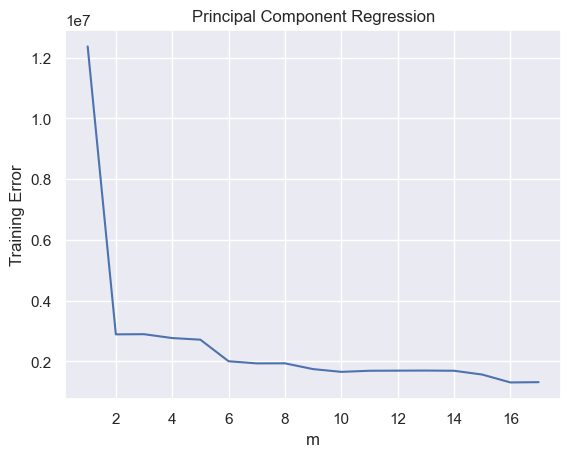

test mse
Test MSE for PCR:  3515228.9024008675


Pipeline(steps=[('pca', PCA(n_components=6)),
                ('linearregression', LinearRegression())])

In [40]:
#c
def elbow_pcr_nator(df):
    X = df.drop(['Apps', 'Unnamed: 0'], axis=1)
    y = df['Apps']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    scalar = StandardScaler() 
    scalar.fit(X_train)
    X_train_scaled = scalar.transform(X_train) 
    X_test_scaled = scalar.transform(X_test)

    # Storing the MSEs
    train_error = {}

    # Perform PCR for all possible number of principal components
    for m in range(1, len(X_train.columns)+1):
        pcr = make_pipeline(
            StandardScaler(), # First Transformer - scale the data
            PCA(n_components=m), # Second Transformer - PCA to find M number of principal components
            LinearRegression()
        ).fit(X_train, y_train)

        train_error[m] = np.mean(-1 *cross_val_score(pcr, X_train_scaled,
                        y_train, cv=KFold(n_splits=10,
                    random_state=1,
                    shuffle=True), scoring='neg_mean_squared_error'))
        
    # Visualize the results:
    # graph train_error by m number of principle component features
    fig, ax = plt.subplots(facecolor='white')
    ax.plot(list(train_error.keys()), list(train_error.values()))
    ax.set_xlabel('m')
    ax.set_ylabel('Training Error')
    ax.set_title('Principal Component Regression')

    plt.show()
    print('test mse', )

    return pcr

elbow_pcr_nator(college)

def min_error_pcr(df):
    X = df.drop(['Apps', 'Unnamed: 0'], axis=1)
    y = df['Apps']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    scalar = StandardScaler() 
    scalar.fit(X_train)
    X_train_scaled = scalar.transform(X_train) 
    X_test_scaled = scalar.transform(X_test)

    pcr = make_pipeline(PCA(n_components=.5), LinearRegression())
    pcr = make_pipeline(PCA(n_components=6), LinearRegression())
    # Fit the PCR pipeline on the training data
    pcr.fit(X_train_scaled, y_train)
    # Assess the fit using the test data
    y_predict = pcr.predict(X_test_scaled)
    #obtain the test error
    test_mse = mean_squared_error(y_test, y_predict)
    print("Test MSE for PCR: ", test_mse)

    return pcr

min_error_pcr(college)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


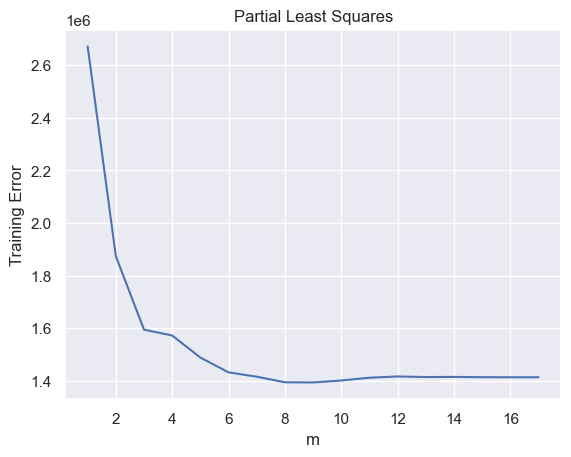

Test MSE for PLS:  31776741.22763204


31776741.22763204

In [44]:

def pls_nator(df):
    X = df.drop(['Apps', 'Unnamed: 0'], axis=1)
    y = df['Apps']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=37)

    # scale the data
    scalar = StandardScaler() 
    scalar.fit(X_train)
    X_train_scaled = scalar.transform(X_train) 
    X_test_scaled = scalar.transform(X_test)
    # Storing the MSEs
    train_error2 = {}

    # Perform PCR for all possible number of principal components
    for m in range(1, len(X_train.columns)+1):
        pls = PLSRegression(
            n_components=m,
            scale=True
        ).fit(X_train, y_train)
        
        train_error2[m] = np.mean(-1*cross_val_score(pls, X_train_scaled,
                        y_train, cv=KFold(n_splits=10,
                        random_state=1,
                        shuffle=True), scoring='neg_mean_squared_error'))
    
    # fit and predict a regression model using three transformed features
    pls = PLSRegression(
        n_components=8,
        scale=True
    ).fit(X_train, y_train)
    y_predict = pls.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_predict)
    

    # Visualize the results
    fig, ax = plt.subplots(facecolor='white')
    ax.plot(list(train_error2.keys()), list(train_error2.values()))
    ax.set_xlabel('m')
    ax.set_ylabel('Training Error')
    ax.set_title('Partial Least Squares')

    plt.show()

    print("Test MSE for PLS: ", test_mse)
    

    return test_mse

pls_nator(college)

(a) Sketch the tree corresponding to the partition of the predictor space illustrated in the
left-hand panel of the figure. The numbers inside the boxes indicate the mean of Y
within each region.

- see attached PDF

(b) Create a diagram similar to the left-hand panel of the figure, using the tree illustrated in
the right-hand panel of the same figure. You should divide up the predictor space into
the correct regions, and indicate the mean for each region.

- See attached PDF

3.) (ISLP: Chapter 8, Question 9) This question involves the OJ data set which is available on
Canvas

(a) Create a training set and a test set. Please use a 70/30 training/test split and set
random_state=3 when you split the data.

(b) Fit a full, unpruned tree to the training data, with Purchase as the response and the
other variables as predictors. When calling the DecisionTreeClassifier() function, please set random_state=2 . What is the training error rate?

- Training error rate: 0.006675567423230944 99% accuracy score! The model fits the data really well, though that might be an issue with overfitting in the future. 

(c) Create a plot of the full, unpruned tree from the previous question. 5 The plot is a
mess, isn’t it? For the purposes of this question, fit another tree with the max_depth
parameter set to 3 in order to get an interpretable plot. How many terminal nodes does
the tree have? Interpret the information displayed in the first (when reading from left
to right) of the terminal nodes on your plot.

- dont have any terminal nodes where the probability is 100% or 0. But that's normal for max-depth. The values decrease quickly and the gini value only increases for the first few branches then it increases. 

(d) Use your fit of the full, unpruned tree to predict the response on the test data, and
produce a confusion matrix comparing the test labels to the predicted test labels. What
is the test error rate?

- 0.2461059190031153 which is increased from the training but still a good fit for the model. 

Training Accuracy: 0.9933244325767691
Training error rate: 0.006675567423230944
Test Accuracy: 0.7601246105919003


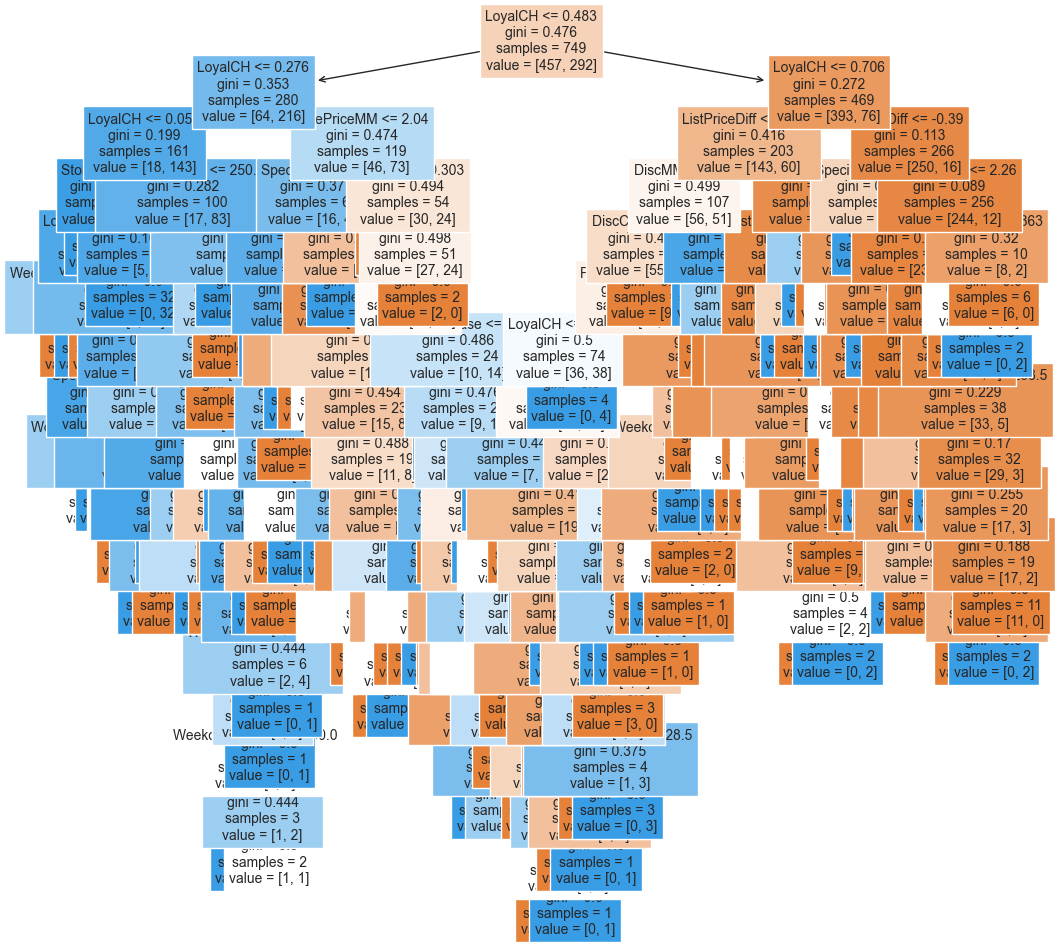

Test Error Rate: 0.23987538940809972
Confusion Matrix:
Test Accuracy: 0.7601246105919003
Test Error Rate: 0.23987538940809972
Training Accuracy: 0.8210947930574098
Test Accuracy: 0.8068535825545171


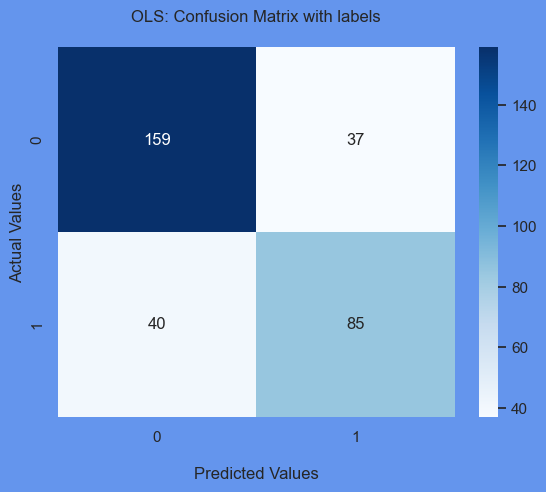

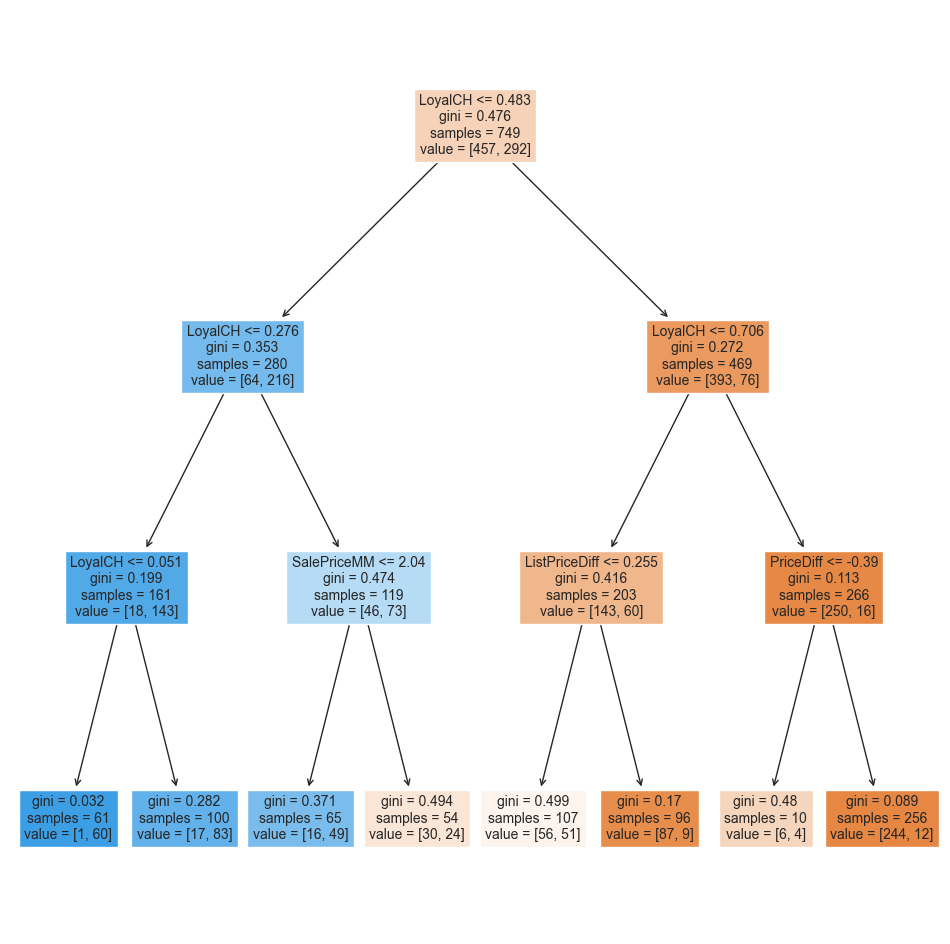

DecisionTreeClassifier(random_state=2)

In [47]:
oj = pd.read_csv('Data-OJ.csv')
oj['Store7'] = oj['Store7'].replace({'Yes': 1, 'No': 0})

def unpruned_nator(df):
    X = df.drop(['Purchase'], axis=1)
    y = df['Purchase']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # No stopping criterion
    full_model = DecisionTreeClassifier(
        random_state=2,
        criterion='gini')
    full_model.fit(X_train, y_train)

    print(f'Training Accuracy: {full_model.score(X_train, y_train)}')
    print(f'Training error rate: {1 - full_model.score(X_train, y_train)}')
    print(f'Test Accuracy: {full_model.score(X_test, y_test)}')

    # Plot the decision tree
    plt.figure(figsize=(12,12), facecolor='white')
    tree.plot_tree(full_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
    plt.show()

    # Predict on the test data
    y_hat_test = full_model.predict(X_test)

    # Calculate confusion matrix
    y_hat_test = full_model.predict(X_test)
    cm = confusion_matrix(y_test, y_hat_test)

    sns.set(rc={'figure.facecolor': 'cornflowerblue'})
    ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
    ax.set_title('OLS: Confusion Matrix with labels\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    print("Test Error Rate:", 1-accuracy_score(y_test, y_hat_test))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_hat_test)

    print("Confusion Matrix:")
    print("Test Accuracy:", accuracy)
    print("Test Error Rate:", 1 - accuracy)

    # Maximum depth
    max_depth_model = DecisionTreeClassifier(
    max_depth=3,
    random_state=1,
    criterion='gini').fit(X_train, y_train)

    print(f'Training Accuracy: {max_depth_model.score(X_train, y_train)}')
    print(f'Test Accuracy: {max_depth_model.score(X_test, y_test)}')

    plt.figure(figsize=(12,12), facecolor='white')
    tree.plot_tree(max_depth_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
    plt.show()

    return full_model

unpruned_nator(oj)


e) Use cost complexity pruning to determine the optimal subtree for prediction by tuning
the the α hyperparameter.6 Use 5-fold cross-validation (5FCV) to choose the optimal value of the hyperparameter.7 Produce a plot with the values of α (ccp_alpha) on the x-axis and the cross-validated classification error rate on the y-axis. Which α
corresponds to the lowest cross-validated classification error rate?

- The lowest classification error rate is 0.19225055928411638.
- The alpha that corresponds to this value is 0.0047063975958152315


(f) Now produce a second plot showing the tree size on the x-axis and the cross-validated
classification error rate (that you calculated in the method in the previous question) on
the y-axis.8 Which tree size corresponds to the lowest cross-validated classification
error rate? Briefly explain why the value of α affects the tree size and the classification
error rate.

- the tree size is 9 
- the smaller the value of alpha, the more likely we are to overfit the data. in reverse, the larger the value of alpha, the smaller the number of nodes is and the tree will be less complex. Alpha is a regularization parameter. 

Test Error: 0.23987538940809972
Training Error: 0.7601246105919003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


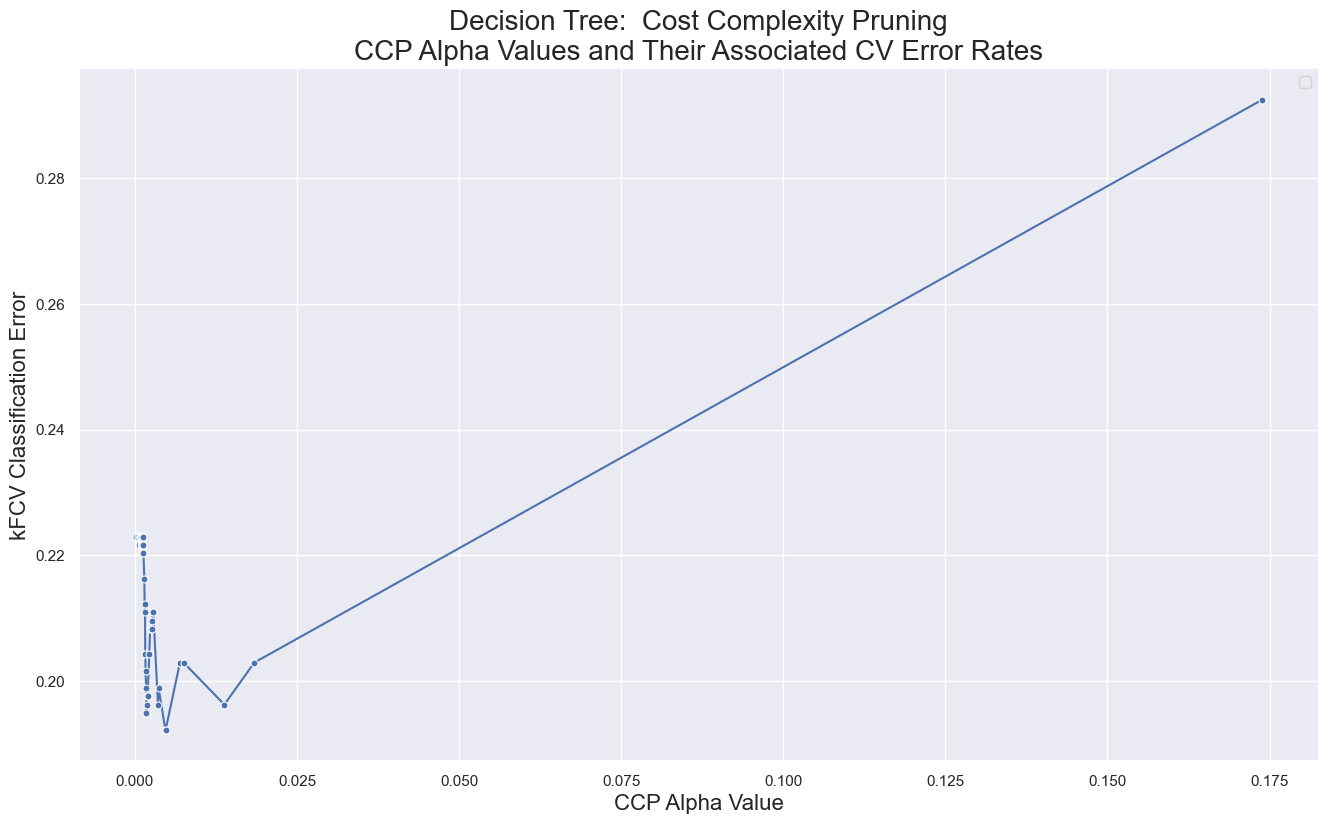

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


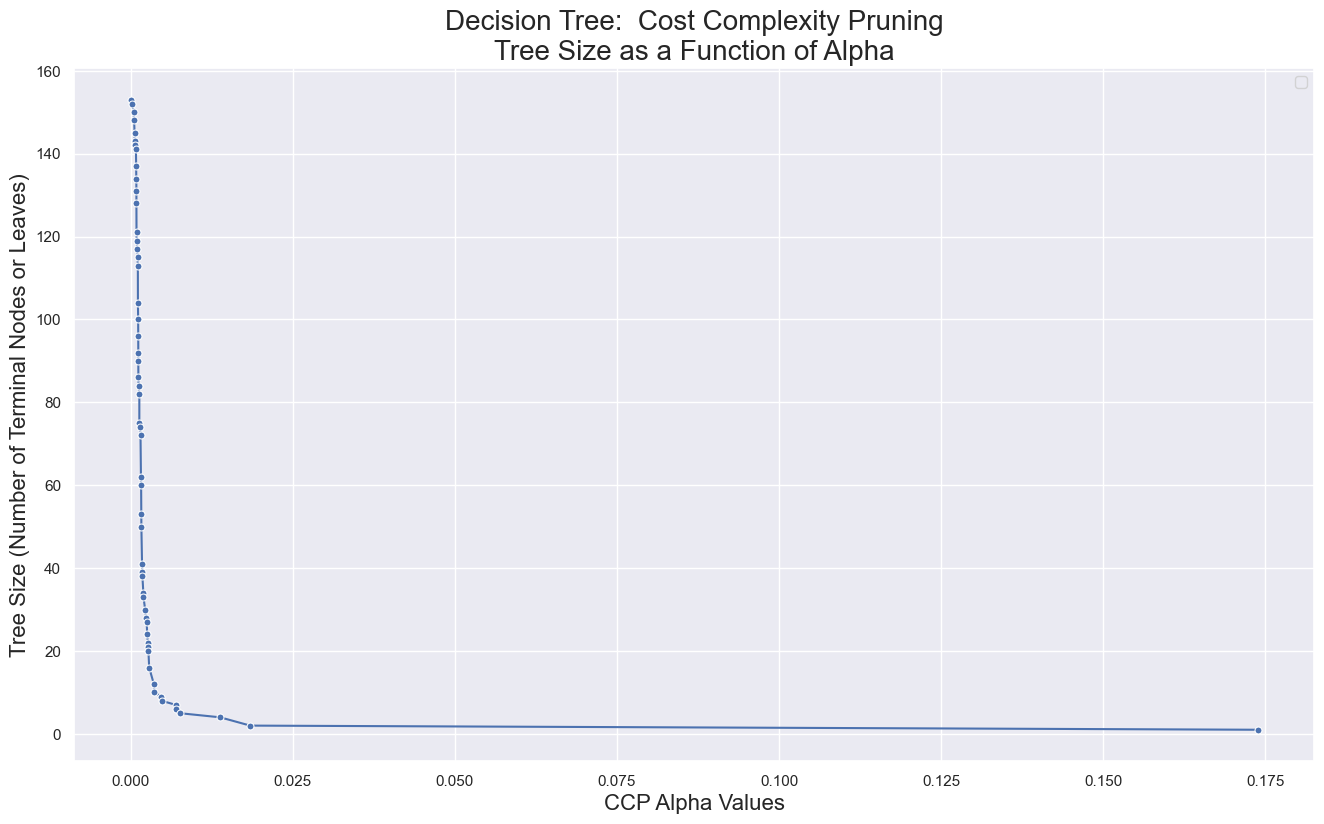

The lowest classification error rate is 0.19225055928411638.
The alpha that corresponds to this value is 0.0047063975958152315
The tree size that corresponds to this value is 9


9

In [67]:
#e
def ccp_nator(df):
    X = df.drop(['Purchase'], axis=1)
    y = df['Purchase']

        # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
        
        # No stopping criterion
    full_model = DecisionTreeClassifier(
            random_state=2,
            criterion='gini')
    full_model.fit(X_train, y_train)

    # ... and save the corresponding CV error for each alpha level
    print(f'Test Error: {1 - full_model.score(X_test, y_test)}')
    print(f'Training Error: {full_model.score(X_test, y_test)}')

    # use the .cost_complexity_pruning_path() function to fit various values of α to the training data
    path = full_model.cost_complexity_pruning_path(X_train, y_train)
    # get list of ccp_alpha values created for experimentation
    ccp_alphas = path.ccp_alphas
    #  save these values in a dictionary
    parameters = {'ccp_alpha': ccp_alphas}

    # Use GridSearchCV to iterate over the CCP alphas... 
    kf = KFold(n_splits=5, random_state = 2, shuffle=True)
    cv_tree = GridSearchCV(full_model, parameters, cv = kf, scoring='accuracy')
    cv_tree.fit(X_train, y_train)

    cv_scores = []
    for mean_score in cv_tree.cv_results_["mean_test_score"]:
        # create list of error rates produced by each corresponding ccp_alpha 
        # (errors are saved in the same order as their alpha values appear in the ccp_alpha list)
        cv_scores.append(1-mean_score)

    fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
    sns.lineplot(x=ccp_alphas, y=cv_scores, marker='o', markersize=5, ax=ax)
    ax.set_ylabel("kFCV Classification Error", fontsize=16)
    ax.set_xlabel("CCP Alpha Value", fontsize=16)
    ax.set_title('Decision Tree:  Cost Complexity Pruning'
                '\nCCP Alpha Values and Their Associated CV Error Rates',
                fontsize=20)
    plt.legend()
    plt.show()
    
    ########### f #######
    # Plot the tree size as a function of alpha
    tree_size = []
    for a in ccp_alphas:
        clf_a = DecisionTreeClassifier(ccp_alpha=a, random_state=2, criterion='gini')
        clf_a.fit(X_train, y_train)
        tree_size.append(clf_a.get_n_leaves())

    fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
    sns.lineplot(x=ccp_alphas, y=tree_size, marker='o', markersize=5, ax=ax)
    ax.set_ylabel("Tree Size (Number of Terminal Nodes or Leaves)", fontsize=16)
    ax.set_xlabel("CCP Alpha Values", fontsize=16)
    ax.set_title('Decision Tree:  Cost Complexity Pruning'
                '\nTree Size as a Function of Alpha',
                fontsize=20)
    plt.legend()
    plt.show()

    # determine the alpha value where the minimum cv error occured
    min_error = min(cv_scores)
    idx = np.where(cv_scores == min_error)[0][0]
    alpha_at_min_error = ccp_alphas[idx]
    # and get the size of the tree at this alpha value
    size_at_min_error = tree_size[idx]

    print(f"The lowest classification error rate is {min_error}."
        f"\nThe alpha that corresponds to this value is {alpha_at_min_error}"
        f"\nThe tree size that corresponds to this value is {size_at_min_error}")
    
    

    return size_at_min_error

ccp_nator(oj)

(g) Produce a plot of the optimal pruned subtree obtained using cross-validation.




(h) Compare the training error rates between the pruned and unpruned trees. Which is
higher? Briefly explain.
- Training Error up: 0.7601246105919003
- Training Error of pruned: 0.8037383177570093
- the training error is slightly worse with the pruned model which makes sense as we're giving up some complexity for intrepretability so with a less complex model were bound to have less of something fit to the training model. This just shows that the model is working. 


(i) Compare the test error rates between the pruned and unpruned trees. Which is higher?
Briefly explain

- Test Error UP: 0.23987538940809972
- Test Error pruned: 0.19626168224299068

- The higher error rate is the unpruned model, which makes sense since we lowered the complexity of the model and it's less likely to overfit for the training data. 

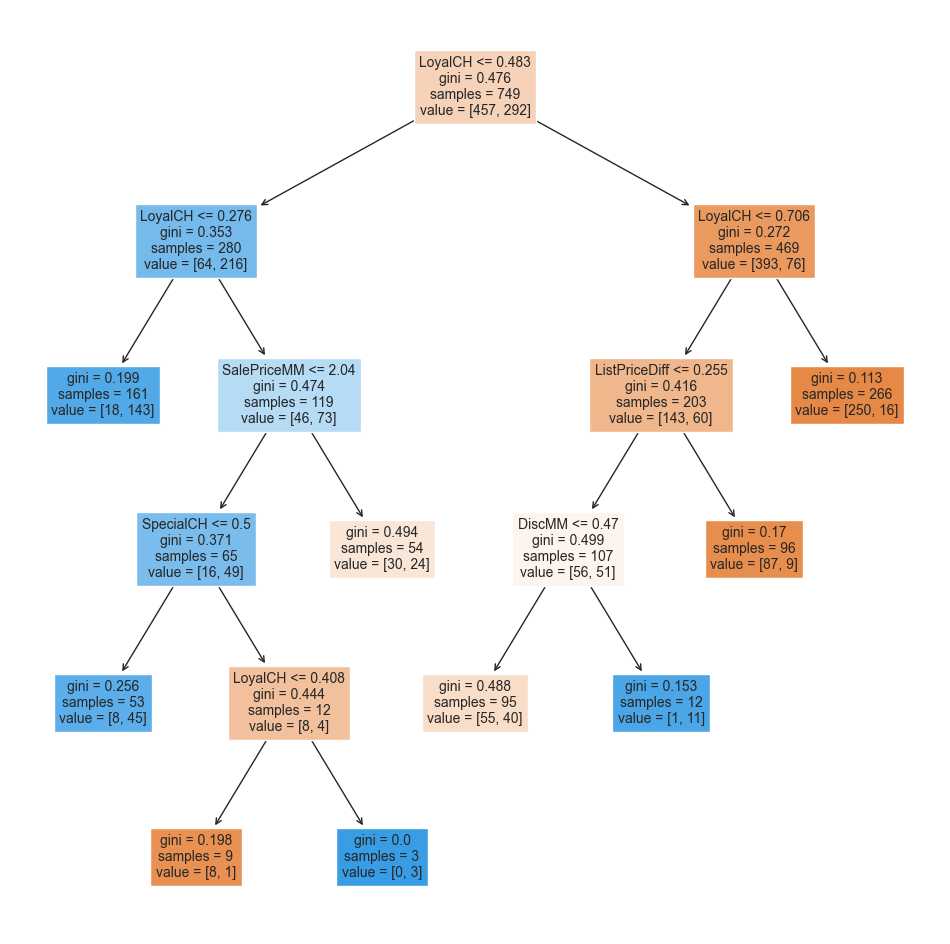

Test Error: 0.19626168224299068
Training Error: 0.8037383177570093


DecisionTreeClassifier(ccp_alpha=0.0047063975958152315, random_state=2)

In [60]:
def optimal_prune_nator(df):
    X = df.drop(['Purchase'], axis=1)
    y = df['Purchase']

            # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

    pruned_model = DecisionTreeClassifier(ccp_alpha=0.0047063975958152315, random_state=2, 
                                        criterion='gini').fit(X_train, y_train)

    #show a visual display of the tree
    plt.figure(figsize=(12,12), facecolor='white')
    tree.plot_tree(pruned_model, fontsize=10, feature_names=X_train.columns.tolist(), filled=True)
    plt.show()

    # make predictions on the test set using the optimal, pruned tree model
    print(f'Test Error: {1 - pruned_model.score(X_test, y_test)}')
    print(f'Training Error: {pruned_model.score(X_test, y_test)}')
    return pruned_model

optimal_prune_nator(oj)

